In [18]:
import numpy as np


import os
from collections import defaultdict
from elastica.wrappers import BaseSystemCollection, Constraints, Forcing, CallBacks
from elastica.rod.cosserat_rod import CosseratRod
from elastica.external_forces import MuscleTorques
from elastica.interaction import SlenderBodyTheory
from elastica.callback_functions import CallBackBaseClass
from elastica.timestepper.symplectic_steppers import PositionVerlet, PEFRL
from elastica.timestepper import integrate

from matplotlib import pyplot as plt
from matplotlib.colors import to_rgb




In [ ]:
class FlagellaSimulator(BaseSystemCollection, Constraints, Forcing, CallBacks):
    pass

flagella_sim = FlagellaSimulator()



In [ ]:
# setting up test params
n_elem = 50
start = np.zeros((3,))
direction = np.array([0.0, 0.0, 1.0])
normal = np.array([0.0, 1.0, 0.0])
base_length = 1.0
base_radius = 0.025
base_area = np.pi * base_radius ** 2
density = 1000
nu = 5.0
E = 1e7
poisson_ratio = 0.5

shearable_rod = CosseratRod.straight_rod(
    n_elem,
    start,
    direction,
    normal,
    base_length,
    base_radius,
    density,
    nu,
    E,
    poisson_ratio,
    )

flagella_sim.append(shearable_rod)

In [20]:
period = 1.0

# Add muscle forces on the rod
b_coeff = np.array([17.4, 48.5, 5.4, 14.7, 0.38])
wave_length = b_coeff[-1]

flagella_sim.add_forcing_to(shearable_rod).using(
    MuscleTorques,
    base_length=base_length,
    b_coeff=b_coeff[:-1],
    period=period,
    wave_number=2.0 * np.pi / (wave_length),
    phase_shift=0.0,
    ramp_up_time=period,
    direction=normal,
    with_spline=True,
)


In [53]:

# Add slender body forces
fluid_density = 1.0
reynolds_number = 1e-4
dynamic_viscosity = (fluid_density*base_length**2/(period*reynolds_number))
flagella_sim.add_forcing_to(shearable_rod).using(SlenderBodyTheory, dynamic_viscosity=dynamic_viscosity)

In [21]:
# Add call backs
class ContinuumFlagellaCallBack(CallBackBaseClass):
    """
    Call back function for continuum flagella
    """

    def __init__(self, step_skip: int, callback_params: dict):
        CallBackBaseClass.__init__(self)
        self.every = step_skip
        self.callback_params = callback_params

    def make_callback(self, system, time, current_step: int):

        if current_step % self.every == 0:

            self.callback_params["time"].append(time)
            self.callback_params["step"].append(current_step)
            self.callback_params["position"].append(system.position_collection.copy())
            self.callback_params["velocity"].append(system.velocity_collection.copy())
            self.callback_params["avg_velocity"].append(system.compute_velocity_center_of_mass())
            self.callback_params["center_of_mass"].append(system.compute_position_center_of_mass())
            
            return

pp_list = defaultdict(list)
flagella_sim.collect_diagnostics(shearable_rod).using(
    ContinuumFlagellaCallBack, step_skip=200, callback_params=pp_list
)

In [ ]:
flagella_sim.finalize()

In [22]:
timestepper = PositionVerlet()

final_time = (5.0 + 0.01) * period
dt = 2.5e-5 * period
total_steps = int(final_time / dt)
print("Total steps", total_steps)



Total steps 200399


In [23]:
integrate(timestepper, flagella_sim, final_time, total_steps)


100%|██████████| 200399/200399 [01:49<00:00, 1837.98it/s]

Final time of simulation is :  5.009999999967631


In [ ]:
def compute_projected_velocity(plot_params: dict, period):

    time_per_period = np.array(plot_params["time"]) / period
    avg_velocity = np.array(plot_params["avg_velocity"])
    center_of_mass = np.array(plot_params["center_of_mass"])

    # Compute rod velocity in rod direction. We need to compute that because,
    # after snake starts to move it chooses an arbitrary direction, which does not
    # have to be initial tangent direction of the rod. Thus we need to project the
    # snake velocity with respect to its new tangent and roll direction, after that
    # we will get the correct forward and lateral speed. After this projection
    # lateral velocity of the snake has to be oscillating between + and - values with
    # zero mean.

    # Number of steps in one period.
    period_step = int(period / (time_per_period[-1] - time_per_period[-2])) + 1
    number_of_period = int(time_per_period.shape[0] / period_step)
    # Center of mass position averaged in one period
    center_of_mass_averaged_over_one_period = np.zeros((number_of_period - 2, 3))
    for i in range(1, number_of_period - 1):
        # position of center of mass averaged over one period
        start = center_of_mass[(i+1)*period_step:(i+2)*period_step]
        stop  = center_of_mass[(i+0)*period_step:(i+1)*period_step]
        center_of_mass_averaged_over_one_period[i - 1] = np.mean(start - stop, axis=0)

    # Average the rod directions over multiple periods and get the direction of the rod.
    direction_of_rod = np.mean(center_of_mass_averaged_over_one_period, axis=0)
    direction_of_rod /= np.linalg.norm(direction_of_rod, ord=2)

    # Compute the projected rod velocity in the direction of the rod
    velocity_mag_in_direction_of_rod = np.einsum("ji,i->j", avg_velocity, direction_of_rod)
    velocity_in_direction_of_rod = np.einsum("j,i->ji", velocity_mag_in_direction_of_rod, direction_of_rod)

    # Get the lateral or roll velocity of the rod after subtracting its projected
    # velocity in the direction of rod
    velocity_in_rod_roll_dir = avg_velocity - velocity_in_direction_of_rod

    # Compute the average velocity over the simulation, this can be used for optimizing snake
    # for fastest forward velocity. We start after first period, because of the ramping up happens
    # in first period.
    average_velocity_over_simulation = np.mean(velocity_in_direction_of_rod[period_step * 2 :], axis=0)

    return (
        velocity_in_direction_of_rod,
        velocity_in_rod_roll_dir,
        average_velocity_over_simulation[2],
        average_velocity_over_simulation[0],
    )

average forward velocity: 0.013307082535877316 m/s
average forward lateral: -2.0551163680770036e-07 m/s


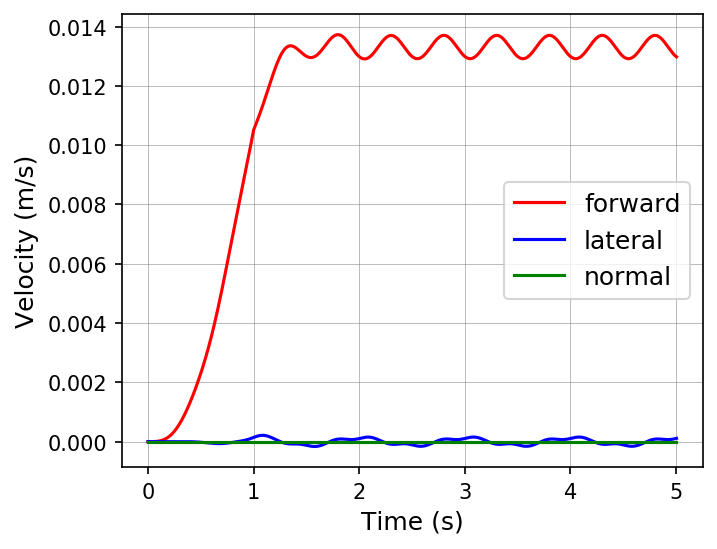

In [47]:
def plot_velocity(plot_params: dict, period, filename="velocity.png", SAVE_FIGURE=False):

    time_per_period = np.array(plot_params["time"]) / period
    avg_velocity = np.array(plot_params["avg_velocity"])

    [velocity_in_direction_of_rod, 
     velocity_in_rod_roll_dir, _, _,] = compute_projected_velocity(plot_params, period)

    fig = plt.figure(figsize=(5,4), frameon=True, dpi=150)
    ax = fig.add_subplot(111)
    ax.grid(b=True, which="major", color="grey", linestyle="-", linewidth = 0.25)
    ax.plot(time_per_period[:], velocity_in_direction_of_rod[:, 2], "r-", label="forward")
    ax.plot(time_per_period[:], velocity_in_rod_roll_dir[:, 0], "b-", label="lateral",)
    ax.plot(time_per_period[:], avg_velocity[:, 1], "g-", label="normal")
    ax.legend(prop={"size": 12})
    ax.set_ylabel('Velocity (m/s)', fontsize = 12)
    ax.set_xlabel('Time (s)', fontsize = 12)
    plt.show()

    if SAVE_FIGURE:
        fig.savefig(filename)

# Compute the average forward velocity. These will be used for optimization.
[_, _, avg_forward, avg_lateral] = compute_projected_velocity(pp_list, period)

print("average forward velocity:", avg_forward, "m/s")
print("average forward lateral:", avg_lateral, "m/s")

# Save Options
SAVE_FIGURE = False
filename_plot = "continuum_flagella_velocity.png"
plot_velocity(pp_list, period, filename_plot, SAVE_FIGURE)

In [52]:
from IPython.display import Video

def plot_video(plot_params: dict, video_name="video.mp4", margin=0.2, fps=15):  # (time step, x/y/z, node)
    import matplotlib.animation as manimation

    positions_over_time = np.array(plot_params["position"])

    print("plot video")
    FFMpegWriter = manimation.writers["ffmpeg"]
    metadata = dict(title="Movie Test", artist="Matplotlib", comment="Movie support!")
    writer = FFMpegWriter(fps=fps, metadata=metadata)
    fig = plt.figure()
    plt.axis("equal")
    with writer.saving(fig, video_name, 100):
        for time in range(1, len(plot_params["time"])):
            x = positions_over_time[time][2]
            y = positions_over_time[time][0]
            fig.clf()
            plt.plot(x, y, "-")
            plt.xlim([0 - margin, 2.5 + margin])
            plt.ylim([-1.25 - margin, 1.25 + margin])
            writer.grab_frame()
    plt.close(fig)
    
filename_video = "continuum_flagella.mp4"
plot_video(pp_list, video_name=filename_video, margin=0.2, fps=200)

Video("continuum_flagella.mp4")

plot video
finished saving video


In [ ]:
# 